#Name :- Sai Narendra Panga
#Reg.no :- 21BCE9868

In [1]:
import numpy as np
import pandas as pd

from sklearn.datasets import make_blobs
from scipy.stats import multivariate_normal

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# matplotlib
plt.rc('font', size=15)
plt.rc('axes', titlesize=18)  
plt.rc('xtick', labelsize=10)  
plt.rc('ytick', labelsize=10)

# seaborn
sns.set(font_scale = 1.2)
sns.set_style('whitegrid')

In [4]:
# Configuration
RANDOM_SEED = 1
N_SAMPLE_SIZE = 1500
N_CLUSTER = 3

In [5]:
def plot_clusters(X, y=None, ax=None, **kwargs):
    """Displays the given data as a scatter plot."""
    if ax is None:
        ax = plt.gca()
        
    sns.scatterplot(
        x=X[:, 0], 
        y=X[:, 1],
        palette='Set2',
        hue=y, 
        ax=ax)
        
    return ax

In [6]:
from matplotlib.patches import Ellipse

def plot_ellipse(x, covar, alpha=0.3, ax=None, **kwargs):
    """Displays for the given covarence matrix an ellipse that
       which represents of the highest spread. 
    """
    if ax is None:
        ax = plt.gca()
    
    for f, a in zip([1, 2, 3], [1., 0.75, 0.5]):
        U, s, Vt = np.linalg.svd(covar)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = f * 2 * np.sqrt(s)

        e = Ellipse(
            x, 
            width, 
            height, 
            angle=angle,
            facecolor='gray',
            **kwargs)

        e.set_alpha(a*alpha)
        ax.add_artist(e)
    
    return ax

In [7]:
def plot_center(x, ax=None, **kwargs):
    """Displays of a center point for the specified coordinate."""
    if ax is None:
        ax = plt.gca()
    
    sns.scatterplot(
        x=[x[0]], 
        y=[x[1]],
        color='red', 
        s=80, 
        alpha=0.8, 
        ax=ax)
    
    return ax

In [8]:
X, y = make_blobs(
    n_samples=N_SAMPLE_SIZE, 
    centers=N_CLUSTER,
    n_features=2,
    random_state=RANDOM_SEED
)

<ipython-input-5-c8fd700fa882>:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


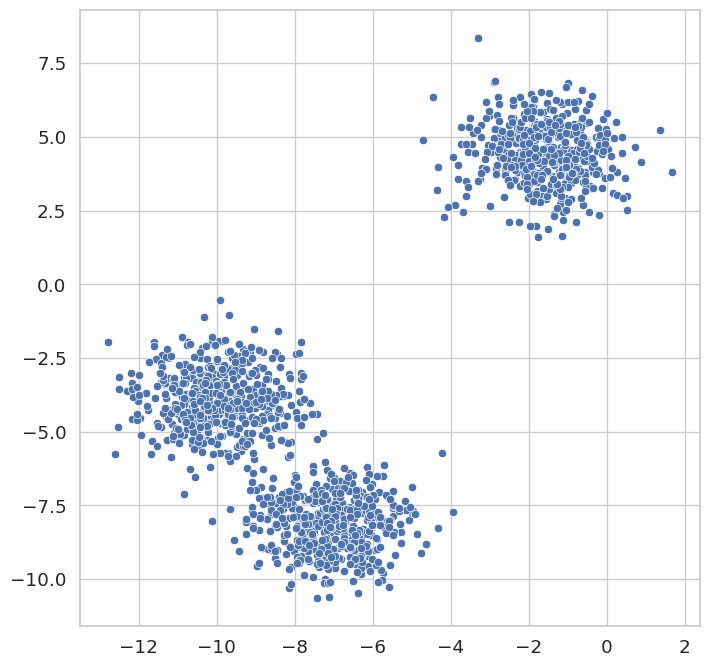

In [9]:
plt.subplots(1, 1, figsize=(8, 8))

plot_clusters(X)
plt.show()

In [10]:
from typing import NamedTuple

class GaussianMixture(NamedTuple):
    """Gaussian mixture parameter set."""
    # (K, dim) array - each row corresponds to a gaussian component mean
    mu: np.ndarray
    
    # (K, ) array - each row corresponds to the variance of a component
    var: np.ndarray
    
    # (K, ) array = each row corresponds to the weight of a component
    p: np.ndarray  

In [11]:
def init(
    X:np.ndarray, 
    num_clusters:int=3, 
    seed=None) -> GaussianMixture:
    """Initializes the gaussian mixture parameters.
    
    Parameters
    ----------
        X: np.ndarray, (N, dim) numpy array of observed data points
        num_clusters: int, number of clusters, optional, default 3
        seed: int, random state, optional, default None

    Returns
    -------
        gm: initialized gaussian mixture parameters
    """
    # data size (N) and dimension (d)
    N, dim = X.shape 
    
    # init mixture component means (μ's)
    sigma = [[1, 0], [0, 1]]
    mu = multivariate_normal.rvs(
        [0, 0], 
        sigma, 
        size=num_clusters, random_state=seed)
        
    # init covariances (Σ's)
    var = [np.identity(dim) for k in range(0, num_clusters)]
    
    # init weights of mixture components
    p = np.ones(num_clusters) / num_clusters
    
    return GaussianMixture(mu, var, p)


In [12]:
def e_step(X:np.ndarray, gm:GaussianMixture) -> np.ndarray:
    """Performing E-Step.
    
    Parameters
    ----------
        X: np.ndarray, (N, dim) numpy array of observed data points
        gm: the current gaussian mixture parameters

    Returns
    -------
        post: the posterior probability p(i|k) that 
              the data point x_i belongs in cluster k.
    """
    N, _ = X.shape
    K, dim = gm.mu.shape # number of clusters (K)
    
    # init posteriors probabilities
    post = np.zeros((N, K))
    
    for k in range(K):
        rv = multivariate_normal(gm.mu[k], gm.var[k])
        post[:, k] = gm.p[k] * rv.pdf(X)
            
    # normalize
    c = np.sum(post, axis=1)[:, np.newaxis]
    post /= c
    
    return post

In [13]:
def m_step(X:np.ndarray, gm:GaussianMixture, post:np.ndarray) -> GaussianMixture:
    """Performing M-Step.
    
    Parameters
    ----------
        X: np.ndarray, (N, dim) numpy array of observed data points.
        gm: the current gaussian mixture parameters.
        post: the posterior probability p(i|k).

    Returns
    -------
        gm: the updated gaussian mixture parameters.
    """
    N, _ = X.shape
    K, dim = gm.mu.shape # number of clusters (K)
    
    # update weights
    w = np.sum(post, axis=0)
    p = w / N

    # update mixture component means (μ's)
    c = np.sum(post, axis=1)[:, np.newaxis]
    mu = np.dot(post.T, X) / w[:, np.newaxis]

    # update covariances (Σ's)
    var = [np.identity(dim) for k in range(0, K)]
    for k in range(K):
        xs = X - gm.mu[k, :]

        p_diag = np.diag(post[:, k])
        p_diag = np.matrix(p_diag)

        sigma = xs.T * p_diag * xs
        var[k] = (sigma) / w[:, np.newaxis][k]    
    
    return GaussianMixture(mu, var, p)

In [14]:
def get_labels(post:np.ndarray) -> np.ndarray:
    """Returns the cluster belonging to the data point."""
    return np.argmax(post, axis=1)

In [15]:
def plot_gaussian_mixture(
    X:np.ndarray, 
    gm:GaussianMixture, 
    post:np.ndarray, 
    ax=None,
    **kwargs):
    """Displays the current state of the 
       Gaussian mixture parameter set."""
    if ax is None:
        ax = plt.gca()
    
    y = get_labels(post)
    plot_clusters(X, y=y, ax=ax)

    for k in range(N_CLUSTER):
        μ = gm.mu[k]
        Σ = gm.var[k]

        plot_center(μ, ax=ax)
        plot_ellipse(μ, Σ, alpha=0.3, ax=ax)
    
    return ax

In [16]:
gm = init(X, num_clusters=N_CLUSTER, seed=RANDOM_SEED)

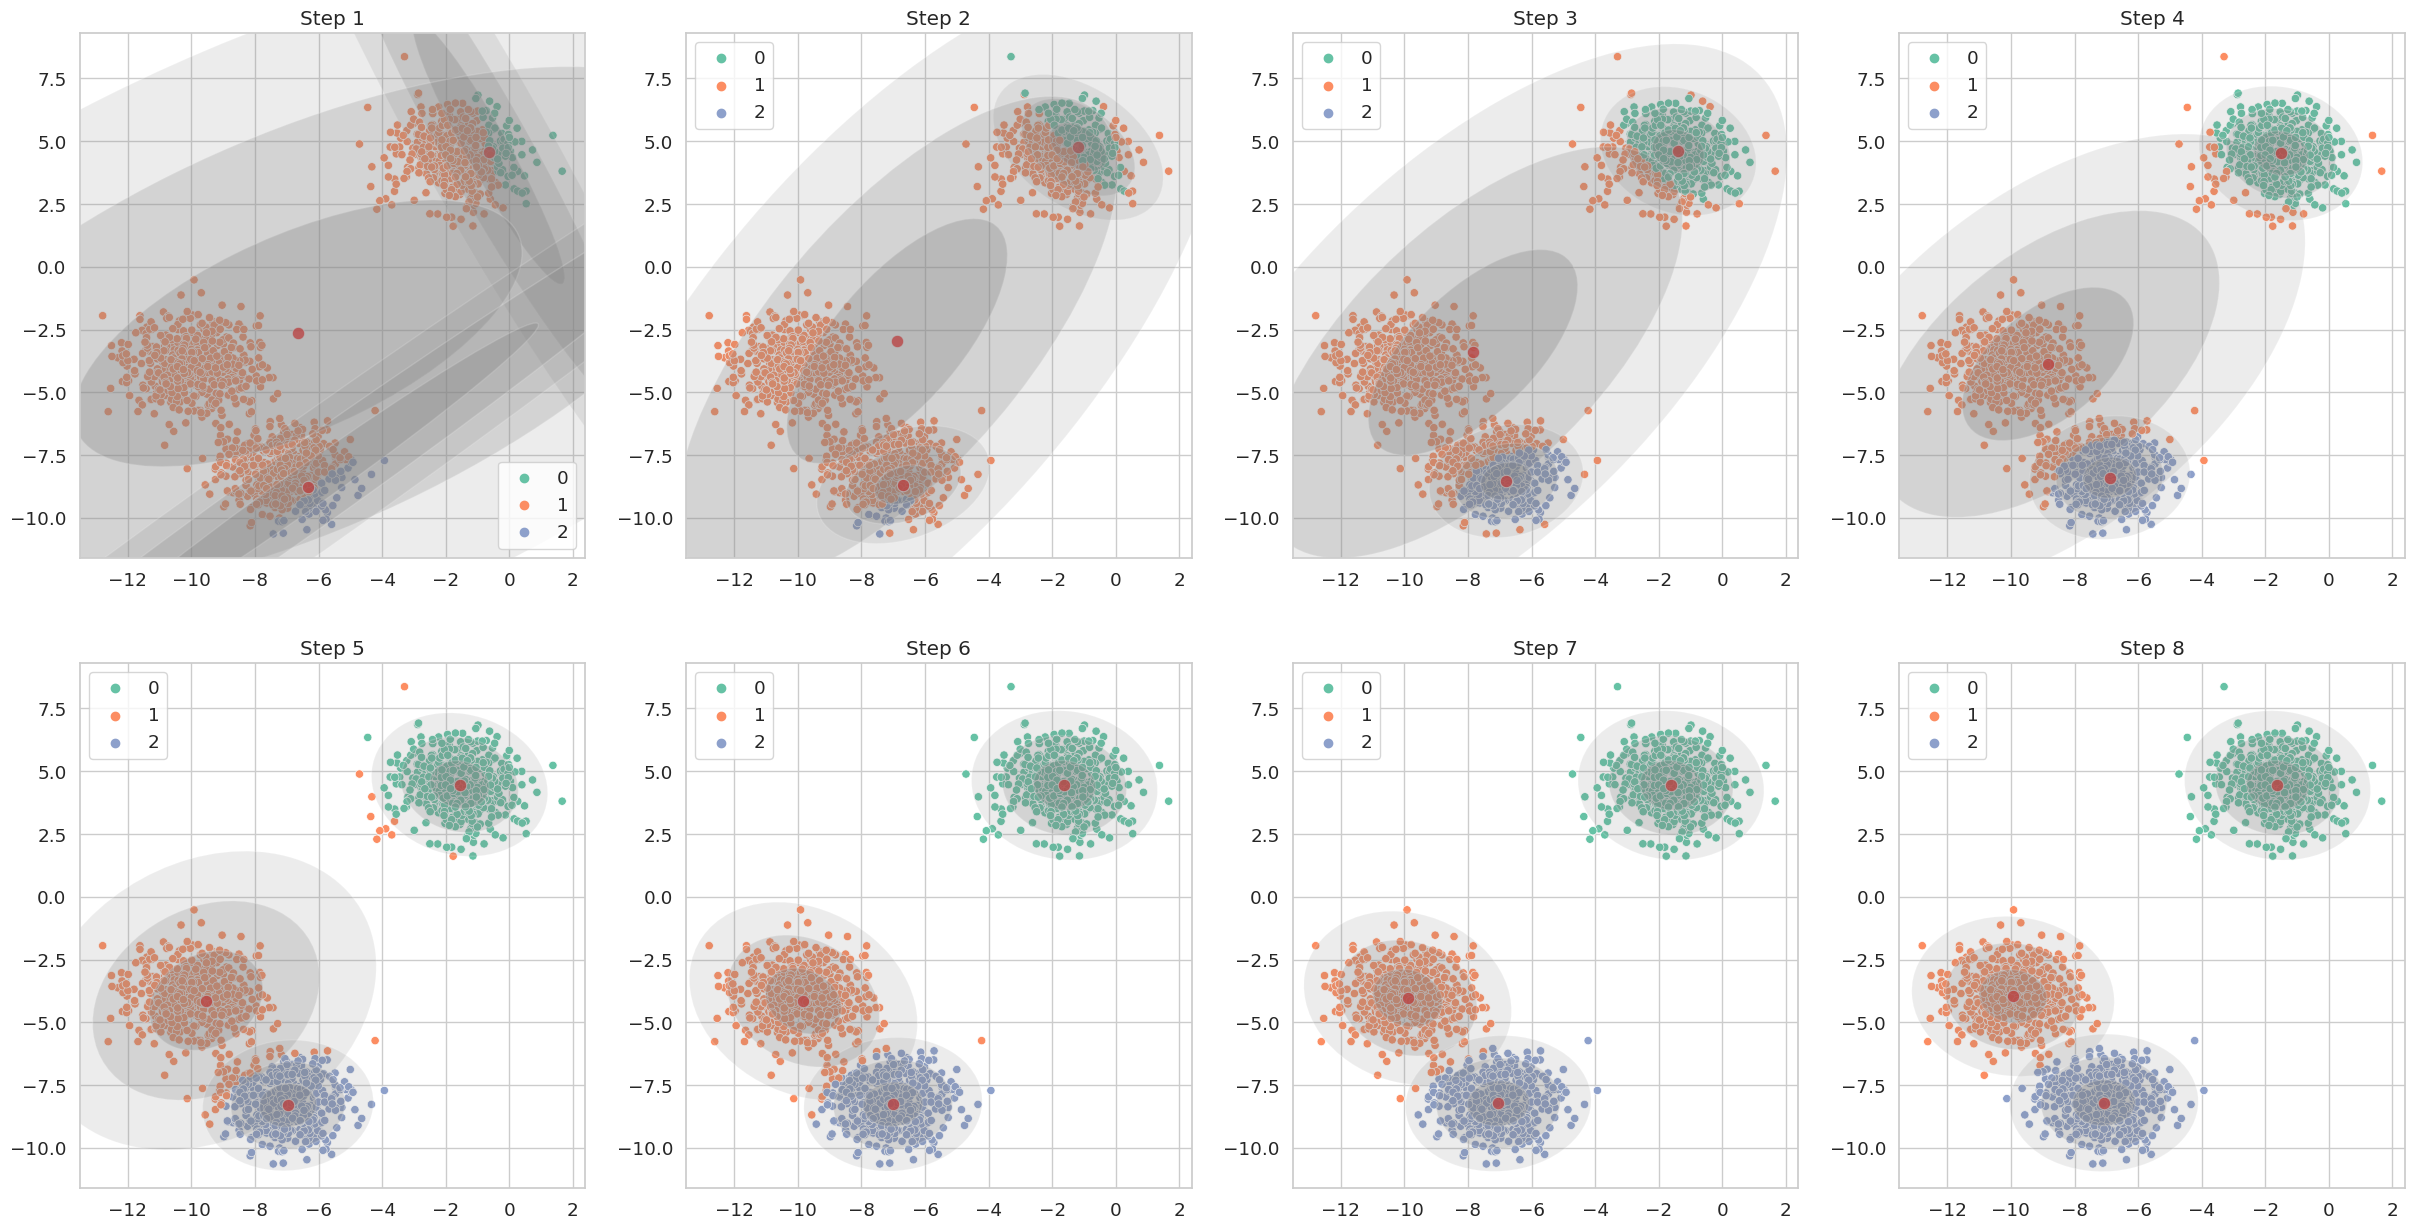

In [17]:
nrows = 2
ncols = 4

fig, axs = plt.subplots(nrows, ncols, figsize=(30, 15))

for (step, ax) in zip(range(nrows*ncols), axs.ravel()):
    post = e_step(X, gm)
    gm = m_step(X, gm, post)
    
    plot_gaussian_mixture(X, gm, post, ax=ax)
    
    ax.set_title(f'Step {step+1}')
    
plt.legend()
plt.show()